# Notebook for performing data cleaning on the dataset
## Import libraries

In [111]:
import pandas as pd
import numpy as np
import wordcloud
import matplotlib.pyplot as plt
import jellyfish

In [112]:
df = pd.read_csv("data.csv")

In [113]:
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


In [114]:
# Drop columns that are not used in this analysis
df = df.drop(columns=['Unnamed: 0',"Job Description","Competitors","Easy Apply"])

## Inspect the data and clean missing or flawed values

In [115]:
print(df.isnull().sum())
df = df.dropna()

Job Title            0
Salary Estimate      0
Rating               0
Company Name         1
Location             0
Headquarters         0
Size                 0
Founded              0
Type of ownership    0
Industry             0
Sector               0
Revenue              0
dtype: int64


Usually the job title is in the form of "Actual title, something else, more info". Thus, we can probably just take the first words before the first comma, or other special character to make the job titles more coherent.


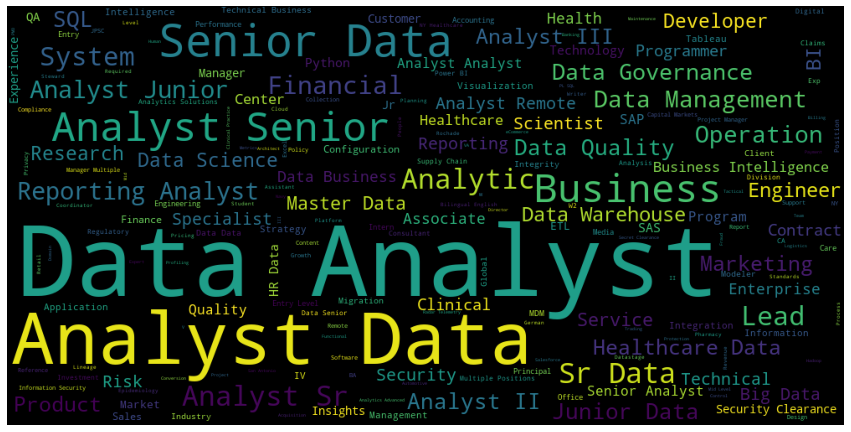

In [116]:
unique_string=(" ").join(df["Job Title"])
wordcloud = wordcloud.WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [117]:
# Top 50 titles from the wordcloud.
new_title_scores = pd.DataFrame.from_dict(wordcloud.words_.items())
new_title_scores.head(5)

,0,1
0,Data Analyst,1.000000
1,Analyst Data,0.472836
2,Senior Data,0.108657
3,Analyst Senior,0.090149
4,Business,0.084179


Now, lets give each job title the most similar string from the wordcloud using Damerau-Levenshtein distance.

In [118]:
def find_most_similar(text,new_titles_list):
    sims = [jellyfish.damerau_levenshtein_distance(text,x) for x in new_titles_list]
    return new_titles_list[sims.index(min(sims))]


In [119]:
df["new_title"] = df["Job Title"].apply(lambda x: find_most_similar(x,new_title_scores[0]))

C:\Users\johma\AppData\Local\Temp/ipykernel_15500/348319044.py:2: DeprecationWarning: getargs: The 'u' format is deprecated. Use 'U' instead.
  sims = [jellyfish.damerau_levenshtein_distance(text,x) for x in new_titles_list]


In [120]:
df["new_title"].value_counts().head(5)

Data Analyst             1314
Senior Analyst            219
Reporting Analyst         165
Analyst Analyst            90
Business Intelligence      56
Name: new_title, dtype: int64

In [121]:
#Remove the "Glassdoor" from salary range
df["Salary Estimate"] = df["Salary Estimate"].apply(lambda s: s.replace(" (Glassdoor est.)",""))

# Remove the "\n" from company names
df["Company Name"] = df["Company Name"].apply(lambda s: s.split("\n")[0])

# Create new features "loc_city" and "hq_city"
df['loc_city'] = df["Location"].apply(lambda s: s.split(",")[0])
df['hq_city'] = df["Headquarters"].apply(lambda s: s.split(",")[0])

# Create min and max salary features
df['min_salary'],df['max_salary']=df['Salary Estimate'].str.split('-').str
df['min_salary']=df["min_salary"].apply(lambda x: float(x.replace('$','').replace('K','') or np.nan))
df['max_salary']=df["max_salary"].apply(lambda x: float(x.replace('$','').replace('K','') or np.nan))


C:\Users\johma\AppData\Local\Temp/ipykernel_15500/1794912181.py:12: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['min_salary'],df['max_salary']=df['Salary Estimate'].str.split('-').str


There are lots of missing values that have been set as "-1". For that reason, we will crudely just replace all "-1" values with nan.

In [122]:
df = df.replace(-1,np.nan).replace(-1.0,np.nan).replace('-1',np.nan)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2252 entries, 0 to 2252
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          2252 non-null   object 
 1   Salary Estimate    2251 non-null   object 
 2   Rating             1981 non-null   float64
 3   Company Name       2252 non-null   object 
 4   Location           2252 non-null   object 
 5   Headquarters       2081 non-null   object 
 6   Size               2090 non-null   object 
 7   Founded            1593 non-null   float64
 8   Type of ownership  2090 non-null   object 
 9   Industry           1900 non-null   object 
 10  Sector             1900 non-null   object 
 11  Revenue            2090 non-null   object 
 12  new_title          2252 non-null   object 
 13  loc_city           2252 non-null   object 
 14  hq_city            2081 non-null   object 
 15  min_salary         2251 non-null   float64
 16  max_salary         2252 

The Founded - feature is missing more values than others. The other features can be imputed naively, but the founding year has a bit too much nan values.

In [124]:
df = df.drop(columns=["Founded"])

Data looks adequate for our EDA, lets start the EDA in another notebook

In [125]:
df.to_csv("clean_data.csv")